## Рекуррентные сети
https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

In [75]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter

In [76]:
max_words = 2000
max_len = 30
num_classes = 1

# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [77]:
import pandas as pd

df = pd.read_csv('train.csv')

In [78]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


0 - negative<br>
1 - positive

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
df_train, df_val = train_test_split(df, test_size=0.3, random_state = 21)

In [81]:
df_train['label'].value_counts()

0    20837
1     1536
Name: label, dtype: int64

In [82]:
df_val['label'].value_counts()

0    8883
1     706
Name: label, dtype: int64

## Классы несбаланстированы. Проведем балансировку классов, тогда показатель accuracyбудет давать более объективную оценку работы модели.

In [83]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [84]:
df_for_balancing = df_train
df_train = balance_df_by_target(df_for_balancing, 'label')
    
df_train['label'].value_counts()

/tmp/ipykernel_6028/1895660404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sample, ignore_index=True)


0    20837
1    19968
Name: label, dtype: int64

In [85]:
df_for_balancing = df_val
df_val = balance_df_by_target(df_for_balancing, 'label')
    
df_val['label'].value_counts()

/tmp/ipykernel_6028/1895660404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sample, ignore_index=True)


0    8883
1    8472
Name: label, dtype: int64

### Предобработка

In [86]:
#!pip install stop-words pymorphy2

In [87]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [88]:
sw = set(get_stop_words("en"))
sw_left = set(['no','not', 'nor', "mustn't", "shouldn't","shan't", 'against', "aren't", "can't",
 'cannot',"wouldn't",
 "couldn't","didn't", "doesn't", "don't", "hadn't", "hasn't","haven't", "isn't", "wasn't", "weren't", "won't"
              ])
sw_in = set(['im', 'u', 'will', 'just'])

In [89]:
sw_left

{'against',
 "aren't",
 "can't",
 'cannot',
 "couldn't",
 "didn't",
 "doesn't",
 "don't",
 "hadn't",
 "hasn't",
 "haven't",
 "isn't",
 "mustn't",
 'no',
 'nor',
 'not',
 "shan't",
 "shouldn't",
 "wasn't",
 "weren't",
 "won't",
 "wouldn't"}

In [90]:
sw.symmetric_difference_update(sw_left)

In [91]:
sw.update(sw_in)

In [92]:
sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'has',
 'have',
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'im',
 'in',
 'into',
 'is',
 'it',
 "it's",
 'its',
 'itself',
 'just',
 "let's",
 'me',
 'more',
 'most',
 'my',
 'myself',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 'so',
 'some',
 'such',
 'than',
 'that',
 "that's",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 "there's",
 'these',
 'they',
 "they'd",

In [93]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [94]:
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
#     txt = re.sub("no\s", "not", 'nore', txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    for word in txt:
        if '@' in word:
            txt.remove(word)
    return " ".join(txt)

In [95]:
df_train['tweet'].iloc[0:1].values

array(["holiday fun, socially relevant! #podcast celebrates '70 bewitched xmas ep   "],
      dtype=object)

In [96]:
df_train['tweet'].iloc[0:1].apply(preprocess_text).values

array(['holiday fun socially relevant podcast celebrates 70 bewitched xmas ep'],
      dtype=object)

In [97]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 17355/17355 [00:01<00:00, 8922.00it/s]


In [98]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [99]:
#!pip install nltk

In [100]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /home/ekaterina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['holiday', 'fun', 'socially', 'relevant', 'podcast']

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [101]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [102]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [103]:
tokens_filtered_top[:10]

['user',
 'amp',
 'not',
 'love',
 'like',
 'trump',
 'day',
 'libtard',
 'people',
 'black']

In [104]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'amp': 2,
 'not': 3,
 'love': 4,
 'like': 5,
 'trump': 6,
 'day': 7,
 'libtard': 8,
 'people': 9,
 'black': 10,
 'white': 11,
 'happy': 12,
 'no': 13,
 'new': 14,
 'can': 15,
 'dont': 16,
 'one': 17,
 'get': 18,
 'us': 19,
 'cant': 20,
 'time': 21,
 'good': 22,
 'today': 23,
 'politics': 24,
 'might': 25,
 'allahsoil': 26,
 'racist': 27,
 'life': 28,
 'liberal': 29,
 'now': 30,
 'hate': 31,
 'feel': 32,
 'see': 33,
 'go': 34,
 'women': 35,
 'positive': 36,
 '2': 37,
 'sjw': 38,
 'want': 39,
 'obama': 40,
 'thankful': 41,
 'great': 42,
 'against': 43,
 'back': 44,
 'got': 45,
 'bihday': 46,
 'make': 47,
 'retweet': 48,
 'girl': 49,
 'take': 50,
 'need': 51,
 'listen': 52,
 'via': 53,
 'racism': 54,
 'work': 55,
 'best': 56,
 'think': 57,
 'fathers': 58,
 'world': 59,
 'first': 60,
 'never': 61,
 'thats': 62,
 'right': 63,
 'youre': 64,
 'really': 65,
 'going': 66,
 'way': 67,
 'smile': 68,
 'thanks': 69,
 'comments': 70,
 'video': 71,
 'america': 72,
 'man': 73,
 'healthy':

In [105]:
import numpy as np


def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [106]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 3.62 s, sys: 0 ns, total: 3.62 s
Wall time: 3.62 s


In [107]:
x_train.shape

(40805, 30)

In [108]:
df_train['tweet'].iloc[1]

'best day ever'

In [109]:
x_train[1]

array([ 56,   7, 100,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [110]:
text_corpus_train = df_train['tweet'].values
text_corpus_valid = df_val['tweet'].values

counts = Counter()
for sequence in text_corpus_train:
    counts.update(sequence.split())

print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))
    
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

num_words before: 37085
num_words after: 14201


In [111]:
max([len(i.split()) for i in text_corpus_train])

24

In [112]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=32, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.5)
               
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # использовать среднее значение
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [113]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [114]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [115]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 30])
torch.Size([512])
tensor(1)


In [116]:
model = GRUFixedLen(len(vocab2index))

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.BCELoss()

In [117]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [118]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(14203, 64, padding_idx=0)
  (gru): GRU(64, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Parameters: 924769


In [119]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [80/80]. Loss: 0.353. Acc: 0.691. Test loss: 0.210. Test acc: 0.805
Epoch [2/10]. Step [80/80]. Loss: 0.287. Acc: 0.877. Test loss: 0.673. Test acc: 0.830
Epoch [3/10]. Step [80/80]. Loss: 0.257. Acc: 0.908. Test loss: 0.057. Test acc: 0.847
Epoch [4/10]. Step [80/80]. Loss: 0.200. Acc: 0.922. Test loss: 0.011. Test acc: 0.835
Epoch [5/10]. Step [80/80]. Loss: 0.208. Acc: 0.929. Test loss: 0.591. Test acc: 0.828
Epoch [6/10]. Step [80/80]. Loss: 0.145. Acc: 0.937. Test loss: 0.002. Test acc: 0.833
Epoch [7/10]. Step [80/80]. Loss: 0.152. Acc: 0.943. Test loss: 0.009. Test acc: 0.843
Epoch [8/10]. Step [80/80]. Loss: 0.116. Acc: 0.948. Test loss: 0.052. Test acc: 0.826
Epoch [9/10]. Step [80/80]. Loss: 0.094. Acc: 0.952. Test loss: 0.002. Test acc: 0.836
Epoch [10/10]. Step [80/80]. Loss: 0.115. Acc: 0.953. Test loss: 1.256. Test acc: 0.837
Training is finished!


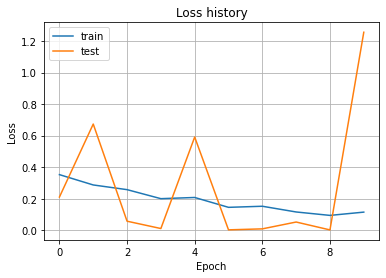

In [120]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

In [121]:
test_outputs.shape

torch.Size([3, 1])

In [122]:
test_outputs.round(), test_labels

(tensor([[1.],
         [1.],
         [0.]], grad_fn=<RoundBackward0>),
 tensor([1, 0, 1]))

Вывод: модель хорошо обучилась, accuracy на трейне 0.95, на тесте 0.84.